## TASKS:
- Create a simple RNN model to predict Sine and Cosine value
- Create a model based on self-Attention to predict Sine and Cosine (from scratch)
- Show the prediction curves , MSE loss.


# Recurrent Neural Networks

## Sine Prediction

In [207]:
import numpy as np
import pandas as pd

# Generate sine and cosine data
x = np.linspace(0, 100, 500)
data = pd.DataFrame({
    'sine': np.sin(x),
    'cosine': np.cos(x),
})

# Add target column (sine values shifted by one timestep)
data['sine_next'] = data['sine'].shift(-1)
data.dropna(inplace=True)


In [3]:
data.head()

,sine,cosine,sine_next
0,0.000000,1.000000,0.199062
1,0.199062,0.979987,0.390157
2,0.390157,0.920749,0.565634
3,0.565634,0.824656,0.718472
4,0.718472,0.695556,0.842552


In [208]:
from sklearn.preprocessing import StandardScaler

# Define predictors and target
PREDICTORS = ["sine", "cosine"]
TARGET = "sine_next"

# Split the data into train, valid, and test sets
np.random.seed(0)
split_data = np.split(data, [int(.7*len(data)), int(.85*len(data))])
(train_x, train_y), (valid_x, valid_y), (test_x, test_y) = [[d[PREDICTORS].to_numpy(), d[[TARGET]].to_numpy()] for d in split_data]


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [5]:
train_x[:5]

array([[0.        , 1.        ],
       [0.19906213, 0.97998687],
       [0.39015654, 0.92074854],
       [0.56563445, 0.82465609],
       [0.71847213, 0.69555574]])

In [6]:
train_y[:5]

array([[0.19906213],
       [0.39015654],
       [0.56563445],
       [0.71847213],
       [0.84255206]])

In [7]:
train_y.shape

(349, 1)

### Initialize parameters(weights of Input layer weights, weights and biases of Hidden layer biases (h_bias), Output layer biases (o_bias))

In [209]:
import math

def init_params(layer_conf):
    layers = []
    for i in range(1, len(layer_conf)):
        np.random.seed(0)
        k = 1/math.sqrt(layer_conf[i]["hidden"])
        i_weight = np.random.rand(layer_conf[i-1]["units"], layer_conf[i]["hidden"]) * 2 * k - k

        h_weight = np.random.rand(layer_conf[i]["hidden"], layer_conf[i]["hidden"]) * 2 * k - k
        h_bias = np.random.rand(1, layer_conf[i]["hidden"]) * 2 * k - k

        o_weight = np.random.rand(layer_conf[i]["hidden"], layer_conf[i]["output"]) * 2 * k - k
        o_bias = np.random.rand(1, layer_conf[i]["output"]) * 2 * k - k

        layers.append(
            [i_weight, h_weight, h_bias, o_weight, o_bias]
        )
    return layers


Forward pass

In [210]:
def forward(x, layers):
    hiddens = []
    outputs = []
    for i in range(len(layers)):
        i_weight, h_weight, h_bias, o_weight, o_bias = layers[i]
        hidden = np.zeros((x.shape[0], i_weight.shape[1]))
        output = np.zeros((x.shape[0], o_weight.shape[1]))
        for j in range(x.shape[0]):
            input_x = x[j,:][np.newaxis,:] @ i_weight
            hidden_x = input_x + hidden[max(j-1,0),:][np.newaxis,:] @ h_weight + h_bias
            hidden_x = np.tanh(hidden_x)
            hidden[j,:] = hidden_x
            output_x = hidden_x @ o_weight + o_bias
            output[j,:] = output_x
        hiddens.append(hidden)
        outputs.append(output)
    return hiddens, outputs[-1]


Backward pass

In [211]:
def backward(layers, x, lr, grad, hiddens):
    for i in range(len(layers)):
        i_weight, h_weight, h_bias, o_weight, o_bias = layers[i]
        hidden = hiddens[i]
        next_h_grad = None
        i_weight_grad, h_weight_grad, h_bias_grad, o_weight_grad, o_bias_grad = [0] * 5

        for j in range(x.shape[0] - 1, -1, -1):
            out_grad = grad[j,:][np.newaxis, :]
            o_weight_grad += hidden[j,:][:, np.newaxis] @ out_grad
            o_bias_grad += out_grad
            h_grad = out_grad @ o_weight.T

            if j < x.shape[0] - 1:
                hh_grad = next_h_grad @ h_weight.T
                h_grad += hh_grad

            tanh_deriv = 1 - hidden[j][np.newaxis,:] ** 2
            h_grad = np.multiply(h_grad, tanh_deriv)
            next_h_grad = h_grad.copy()

            if j > 0:
                h_weight_grad += hidden[j-1][:, np.newaxis] @ h_grad
                h_bias_grad += h_grad

            i_weight_grad += x[j,:][:,np.newaxis] @ h_grad

        lr = lr / x.shape[0]
        i_weight -= i_weight_grad * lr
        h_weight -= h_weight_grad * lr
        h_bias -= h_bias_grad * lr
        o_weight -= o_weight_grad * lr
        o_bias -= o_bias_grad * lr
        layers[i] = [i_weight, h_weight, h_bias, o_weight, o_bias]
    return layers


In [218]:
def mse(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)

def mse_grad(y_true, y_pred):
    return 2 * (y_pred - y_true) / y_true.size

# Training parameters
epochs = 1000
lr = 1e-3

layer_conf = [
    {"type":"input", "units": 2},
    {"type": "rnn", "hidden": 4, "output": 1}
]
layers = init_params(layer_conf)

train_losses = []
valid_losses = []

for epoch in range(epochs):
    sequence_len = 7
    epoch_loss = 0
    for j in range(train_x.shape[0] - sequence_len):
        seq_x = train_x[j:(j + sequence_len), :]
        seq_y = train_y[j:(j + sequence_len), :]
        hiddens, outputs = forward(seq_x, layers)
        grad = mse_grad(seq_y, outputs)
        layers = backward(layers, seq_x, lr, grad, hiddens)
        epoch_loss += mse(seq_y, outputs)

    if epoch % 50 == 0:
        avg_train_loss = epoch_loss / (train_x.shape[0] - sequence_len)
        train_losses.append(avg_train_loss)
        # print(f"Epoch: {epoch} train loss {avg_train_loss}")

    if epoch % 50 == 0:
        sequence_len = 7
        valid_loss = 0
        for j in range(valid_x.shape[0] - sequence_len):
            seq_x = valid_x[j:(j + sequence_len), :]
            seq_y = valid_y[j:(j + sequence_len), :]
            _, outputs = forward(seq_x, layers)
            valid_loss += mse(seq_y, outputs)

        valid_losses.append(valid_loss / (valid_x.shape[0] - sequence_len))

        print(f"Epoch: {epoch} train loss {train_losses[-1]} valid loss {valid_losses[-1]}")


Epoch: 0 train loss 0.5431113887502405 valid loss 0.5320481297811558
Epoch: 50 train loss 0.02642899526254137 valid loss 0.02837993342561999
Epoch: 100 train loss 0.017323320989465353 valid loss 0.01856649562788379
Epoch: 150 train loss 0.012109326324915331 valid loss 0.012946852831211
Epoch: 200 train loss 0.008825173739778078 valid loss 0.009425703625209543
Epoch: 250 train loss 0.006698706813704092 valid loss 0.007151779241645206
Epoch: 300 train loss 0.0052942297356341015 valid loss 0.0056505114234502345
Epoch: 350 train loss 0.00434403243756529 valid loss 0.004633657988640597
Epoch: 400 train loss 0.003680943347722929 valid loss 0.003922682923523089
Epoch: 450 train loss 0.003201402030973811 valid loss 0.0034074784993478775
Epoch: 500 train loss 0.002841737504441504 valid loss 0.0030204443598301368
Epoch: 550 train loss 0.002562709310299284 valid loss 0.0027198829414077355
Epoch: 600 train loss 0.0023397958995568877 valid loss 0.002479675225134596
Epoch: 650 train loss 0.002157312

## MSE loss RNN

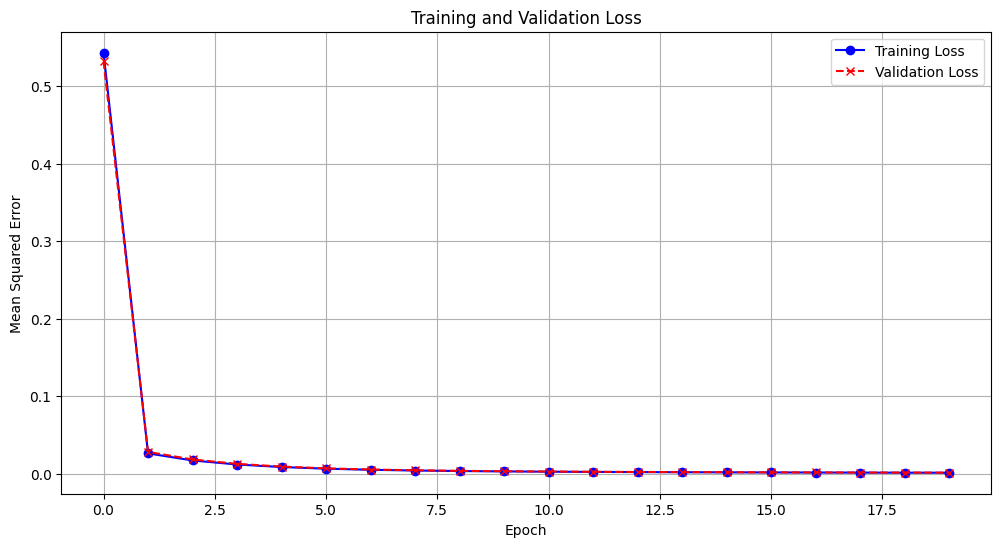

In [219]:
plt.figure(figsize=(12, 6))

plt.plot(train_losses, label='Training Loss', color='blue', linestyle='-', marker='o')

plt.plot(valid_losses, label='Validation Loss', color='red', linestyle='--', marker='x')

plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)

plt.show()

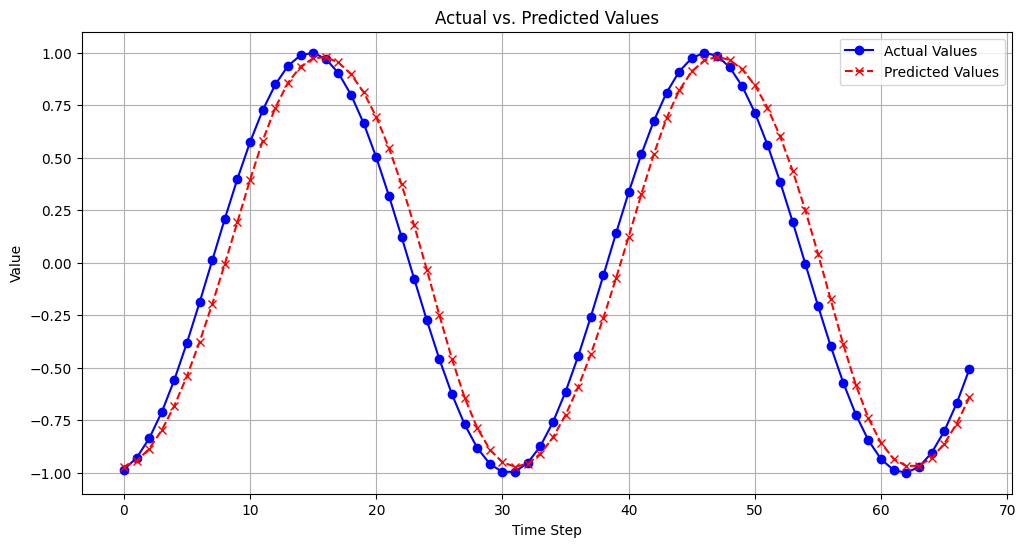

In [ ]:
import matplotlib.pyplot as plt

sequence_len = 7
predictions = []
for j in range(test_x.shape[0] - sequence_len):
    seq_x = test_x[j:(j+sequence_len),]
    _, output = forward(seq_x, layers)
    predictions.append(output[-1, :])  # Include all features in the output

predictions = np.array(predictions)

actual = test_y[sequence_len:sequence_len + len(predictions)]

plt.figure(figsize=(12, 6))


plt.plot(actual, label='Actual Values', color='blue', linestyle='-', marker='o')


plt.plot(predictions, label='Predicted Values', color='red', linestyle='--', marker='x')


plt.xlabel('Time Step')
plt.ylabel('Value')
plt.title('Actual vs. Predicted Values')
plt.legend()
plt.grid(True)


plt.show()

## Cosine Prediction

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

x = np.linspace(0, 100, 500)
data = pd.DataFrame({
    'sine': np.sin(x),
    'cosine': np.cos(x),
})

# Add target column (cosine values shifted by one timestep)
data['cosine_next'] = data['cosine'].shift(-1)
data.dropna(inplace=True)

In [ ]:
PREDICTORS = ["sine", "cosine"]
TARGET = "cosine_next"

np.random.seed(0)
split_data = np.split(data, [int(.7*len(data)), int(.85*len(data))])
(train_x, train_y), (valid_x, valid_y), (test_x, test_y) = [[d[PREDICTORS].to_numpy(), d[[TARGET]].to_numpy()] for d in split_data]


In [ ]:
import math

def init_params(layer_conf):
    layers = []
    for i in range(1, len(layer_conf)):
        np.random.seed(0)
        k = 1/math.sqrt(layer_conf[i]["hidden"])
        i_weight = np.random.rand(layer_conf[i-1]["units"], layer_conf[i]["hidden"]) * 2 * k - k

        h_weight = np.random.rand(layer_conf[i]["hidden"], layer_conf[i]["hidden"]) * 2 * k - k
        h_bias = np.random.rand(1, layer_conf[i]["hidden"]) * 2 * k - k

        o_weight = np.random.rand(layer_conf[i]["hidden"], layer_conf[i]["output"]) * 2 * k - k
        o_bias = np.random.rand(1, layer_conf[i]["output"]) * 2 * k - k

        layers.append(
            [i_weight, h_weight, h_bias, o_weight, o_bias]
        )
    return layers

In [ ]:
def forward(x, layers):
    hiddens = []
    outputs = []
    for i in range(len(layers)):
        i_weight, h_weight, h_bias, o_weight, o_bias = layers[i]
        hidden = np.zeros((x.shape[0], i_weight.shape[1]))
        output = np.zeros((x.shape[0], o_weight.shape[1]))
        for j in range(x.shape[0]):
            input_x = x[j,:][np.newaxis,:] @ i_weight
            hidden_x = input_x + hidden[max(j-1,0),:][np.newaxis,:] @ h_weight + h_bias
            hidden_x = np.tanh(hidden_x)
            hidden[j,:] = hidden_x
            output_x = hidden_x @ o_weight + o_bias
            output[j,:] = output_x
        hiddens.append(hidden)
        outputs.append(output)
    return hiddens, outputs[-1]

In [ ]:
def backward(layers, x, lr, grad, hiddens):
    for i in range(len(layers)):
        i_weight, h_weight, h_bias, o_weight, o_bias = layers[i]
        hidden = hiddens[i]
        next_h_grad = None
        i_weight_grad, h_weight_grad, h_bias_grad, o_weight_grad, o_bias_grad = [0] * 5

        for j in range(x.shape[0] - 1, -1, -1):
            out_grad = grad[j,:][np.newaxis, :]
            o_weight_grad += hidden[j,:][:, np.newaxis] @ out_grad
            o_bias_grad += out_grad
            h_grad = out_grad @ o_weight.T

            if j < x.shape[0] - 1:
                hh_grad = next_h_grad @ h_weight.T
                h_grad += hh_grad

            tanh_deriv = 1 - hidden[j][np.newaxis,:] ** 2
            h_grad = np.multiply(h_grad, tanh_deriv)
            next_h_grad = h_grad.copy()

            if j > 0:
                h_weight_grad += hidden[j-1][:, np.newaxis] @ h_grad
                h_bias_grad += h_grad

            i_weight_grad += x[j,:][:,np.newaxis] @ h_grad

        lr = lr / x.shape[0]
        i_weight -= i_weight_grad * lr
        h_weight -= h_weight_grad * lr
        h_bias -= h_bias_grad * lr
        o_weight -= o_weight_grad * lr
        o_bias -= o_bias_grad * lr
        layers[i] = [i_weight, h_weight, h_bias, o_weight, o_bias]
    return layers

In [ ]:
def mse(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)

def mse_grad(y_true, y_pred):
    return 2 * (y_pred - y_true) / y_true.size

# Training the model
epochs = 1000
lr = 1e-3

layer_conf = [
    {"type":"input", "units": 2},
    {"type": "rnn", "hidden": 4, "output": 1}
]
layers = init_params(layer_conf)

for epoch in range(epochs):
    sequence_len = 7
    epoch_loss = 0
    for j in range(train_x.shape[0] - sequence_len):
        seq_x = train_x[j:(j+sequence_len),]
        seq_y = train_y[j:(j+sequence_len),]
        hiddens, outputs = forward(seq_x, layers)
        grad = mse_grad(seq_y, outputs)
        layers = backward(layers, seq_x, lr, grad, hiddens)
        epoch_loss += mse(seq_y, outputs)

    if epoch % 50 == 0:
        sequence_len = 7
        valid_loss = 0
        for j in range(valid_x.shape[0] - sequence_len):
            seq_x = valid_x[j:(j+sequence_len),]
            seq_y = valid_y[j:(j+sequence_len),]
            _, outputs = forward(seq_x, layers)
            valid_loss += mse(seq_y, outputs)

        print(f"Epoch: {epoch} train loss {epoch_loss / len(train_x)} valid loss {valid_loss / len(valid_x)}")


Epoch: 0 train loss 0.40404059397953124 valid loss 0.36302898717893506
Epoch: 50 train loss 0.01632993413508646 valid loss 0.014482799290537439
Epoch: 100 train loss 0.011499683723076725 valid loss 0.01048913156425181
Epoch: 150 train loss 0.008789602665095762 valid loss 0.008137193926919901
Epoch: 200 train loss 0.006955235345542635 valid loss 0.006537711504443199
Epoch: 250 train loss 0.005658684374828124 valid loss 0.005399827858321931
Epoch: 300 train loss 0.0047133571741025376 valid loss 0.004562757816650248
Epoch: 350 train loss 0.004007128540383742 valid loss 0.003930530435584048
Epoch: 400 train loss 0.0034687123753338487 valid loss 0.003442497437255175
Epoch: 450 train loss 0.0030509185568970846 valid loss 0.0030586699289152264
Epoch: 500 train loss 0.0027215367621834735 valid loss 0.0027517891536983875
Epoch: 550 train loss 0.0024580381042194214 valid loss 0.0025027634413650303
Epoch: 600 train loss 0.0022443425027094187 valid loss 0.0022979143249078284
Epoch: 650 train loss 

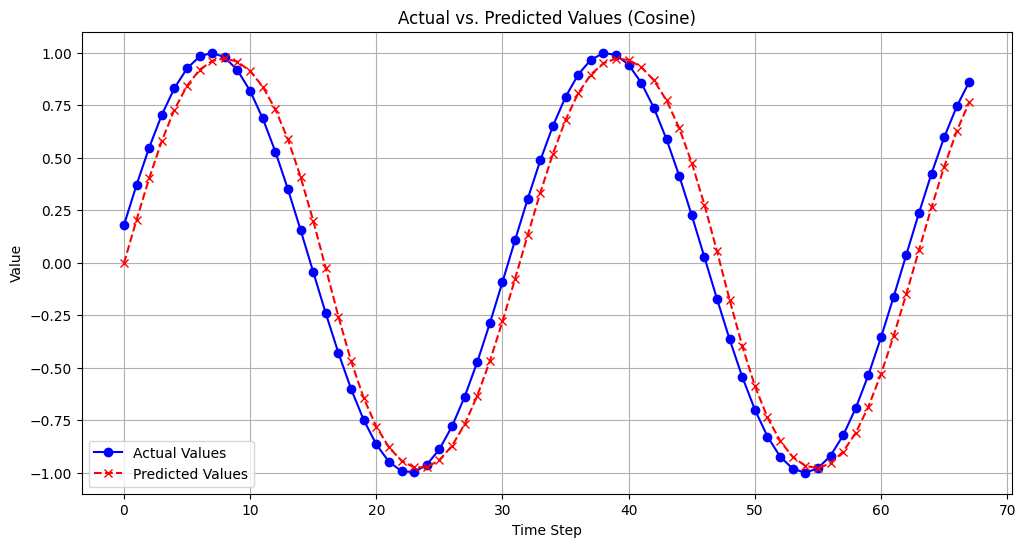

In [ ]:
sequence_len = 7
predictions = []
for j in range(test_x.shape[0] - sequence_len):
    seq_x = test_x[j:(j+sequence_len),]
    _, output = forward(seq_x, layers)
    predictions.append(output[-1, :])  # Include all features in the output

predictions = np.array(predictions)

actual = test_y[sequence_len:sequence_len + len(predictions)]

plt.figure(figsize=(12, 6))

plt.plot(actual, label='Actual Values', color='blue', linestyle='-', marker='o')

plt.plot(predictions, label='Predicted Values', color='red', linestyle='--', marker='x')

plt.xlabel('Time Step')
plt.ylabel('Value')
plt.title('Actual vs. Predicted Values (Cosine)')
plt.legend()
plt.grid(True)

plt.show()

# Self-Attention

## Sine Prediction

In [220]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

x = np.linspace(0, 100, 500)
data = pd.DataFrame({
    'sine': np.sin(x),
    'cosine': np.cos(x),
})

data['sine_next'] = data['sine'].shift(-1)

data.dropna(inplace=True)

PREDICTORS = ["sine", "cosine"]
TARGETS = ["sine_next"]

In [221]:
np.random.seed(0)
split_data = np.split(data, [int(.7*len(data)), int(.85*len(data))])
(train_x, train_y), (valid_x, valid_y), (test_x, test_y) = [
    [d[PREDICTORS].to_numpy(), d[TARGETS].to_numpy()] for d in split_data
]

print("Training data shape:", train_x.shape, train_y.shape)
print("Validation data shape:", valid_x.shape, valid_y.shape)
print("Test data shape:", test_x.shape, test_y.shape)

Training data shape: (349, 2) (349, 1)
Validation data shape: (75, 2) (75, 1)
Test data shape: (75, 2) (75, 1)


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [222]:
train_x[:5]

array([[0.        , 1.        ],
       [0.19906213, 0.97998687],
       [0.39015654, 0.92074854],
       [0.56563445, 0.82465609],
       [0.71847213, 0.69555574]])

In [223]:
train_y[:5]

array([[0.19906213],
       [0.39015654],
       [0.56563445],
       [0.71847213],
       [0.84255206]])

In [224]:
test_y[:5]

array([[-0.34039696],
       [-0.52075905],
       [-0.68027711],
       [-0.81256622],
       [-0.91233135]])

### Initializing weights of query , key , value and output and bias of output


In [225]:
def init_self_attention_params(layer_conf):
    layers = []
    for i in range(1, len(layer_conf)):
        np.random.seed(0)
        # k = 1/math.sqrt(layer_conf[i]["hidden"])
        q_weight = np.random.rand(layer_conf[i-1]["units"], layer_conf[i]["hidden"])
        k_weight = np.random.rand(layer_conf[i-1]["units"], layer_conf[i]["hidden"])
        v_weight = np.random.rand(layer_conf[i-1]["units"], layer_conf[i]["hidden"])
        o_weight = np.random.rand(layer_conf[i]["hidden"], layer_conf[i]["output"])
        o_bias = np.random.rand(1, layer_conf[i]["output"])

        layers.append(
            [q_weight, k_weight, v_weight, o_weight, o_bias]
        )
    return layers

In [226]:
def self_attention_forward(x, layers):
    outputs = []
    attentions = []
    for i in range(len(layers)):
        q_weight, k_weight, v_weight, o_weight, o_bias = layers[i]
        q = x @ q_weight
        k = x @ k_weight
        v = x @ v_weight
        attention, _ = self_attention_scaled_dot_product(q, k, v)
        output = attention @ o_weight + o_bias
        outputs.append(output)
        attentions.append(attention)
    return outputs, attentions


### self attention = softmax(Q.K<sup>T</sup>/root(d<sub>k</sub>) + M)

### new V = self attention.V

In [227]:
def self_attention_scaled_dot_product(q, k, v, mask=None):
    d_k = q.shape[-1]
    scaled = np.matmul(q, k.T) / math.sqrt(d_k)
    if mask is not None:
        scaled = scaled + mask
    attention = self_attention_softmax(scaled)
    out = np.matmul(attention, v)
    return out, attention

### softmax = e<sup>x<sub>i</sub></sup>/ Σ<sub>j</sub> e<sup>x</sup><sub>j</sub>

In [228]:
def self_attention_softmax(x):
    return (np.exp(x).T / np.sum(np.exp(x), axis=-1)).T

In [229]:
def self_attention_backward(layers, x, lr, grad, attentions):
    for i in range(len(layers)):
        q_weight, k_weight, v_weight, o_weight, o_bias = layers[i]
        q_grad = np.zeros_like(q_weight)
        k_grad = np.zeros_like(k_weight)
        v_grad = np.zeros_like(v_weight)
        o_grad = np.zeros_like(o_weight)
        o_bias_grad = np.zeros_like(o_bias)

        attention = attentions[i]

        grad_squeezed = np.squeeze(grad, axis=0)  # Shape: (7, 1)
        # print(grad_aggregated.shape)
        for j in range(x.shape[0]):
            # Gradient for the j-th sequence element
            out_grad = grad_squeezed[j, :][np.newaxis, :]  # Shape: (1, output_units) e.g., (1, 1)
            attention_reshaped = attention[j, :][:, np.newaxis]  # Shape: (hidden_units, 1) e.g., (4, 1)

            # Compute gradients for o_weight and o_bias
            o_grad += np.matmul(attention_reshaped, out_grad)  # (hidden_units, 1) @ (1, output_units) -> (hidden_units, output_units)
            o_bias_grad += out_grad  # (1, output_units)

            # Compute gradient for attention
            attention_grad = np.matmul(out_grad, o_weight.T)  # (1, output_units) @ (output_units, hidden_units) -> (1, hidden_units)

            # Compute gradients for q_weight, k_weight, v_weight
            x_reshaped = x[j, :][:, np.newaxis]  # Shape: (input_units, 1) e.g., (2, 1)
            q_grad += np.matmul(x_reshaped, attention_grad)  # (input_units, 1) @ (1, hidden_units) -> (input_units, hidden_units)
            k_grad += np.matmul(x_reshaped, attention_grad)  # (input_units, 1) @ (1, hidden_units) -> (input_units, hidden_units)
            v_grad += np.matmul(x_reshaped, attention_grad)  # (input_units, 1) @ (1, hidden_units) -> (input_units, hidden_units)

        # Scale learning rate by the batch size
        lr_adjusted = lr / x.shape[0]

        # Update weights and biases
        q_weight -= q_grad * lr_adjusted
        k_weight -= k_grad * lr_adjusted
        v_weight -= v_grad * lr_adjusted
        o_weight -= o_grad * lr_adjusted
        o_bias -= o_bias_grad * lr_adjusted

        # Store updated parameters back into the layers
        layers[i] = [q_weight, k_weight, v_weight, o_weight, o_bias]

    return layers


In [230]:

def mse(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)

def mse_grad(y_true, y_pred):
    return 2 * (y_pred - y_true) / y_true.size

In [233]:
import numpy as np
import matplotlib.pyplot as plt

train_losses = []
valid_losses = []

layer_conf = [
    {"type":"input", "units": 2},
    {"type": "self_attention", "hidden": 8, "output": 1}
]
layers = init_self_attention_params(layer_conf)

# Training parameters
epochs = 1000
lr = 1e-3

for epoch in range(epochs):
    sequence_len = 7
    epoch_loss = 0
    for j in range(train_x.shape[0] - sequence_len):
        seq_x = train_x[j:(j + sequence_len), :]
        seq_y = train_y[j:(j + sequence_len), :]
        outputs, attentions = self_attention_forward(seq_x, layers)
        grad = mse_grad(seq_y, outputs)
        layers = self_attention_backward(layers, seq_x, lr, grad, attentions)
        epoch_loss += mse(seq_y, outputs)



    if epoch % 50 == 0:
        train_losses.append(epoch_loss / (train_x.shape[0] - sequence_len))
        sequence_len = 7
        valid_loss = 0
        for j in range(valid_x.shape[0] - sequence_len):
            seq_x = valid_x[j:(j + sequence_len), :]
            seq_y = valid_y[j:(j + sequence_len), :]
            outputs, _ = self_attention_forward(seq_x, layers)
            valid_loss += mse(seq_y, outputs)

        # Record validation loss
        valid_losses.append(valid_loss / (valid_x.shape[0] - sequence_len))

        print(f"Epoch: {epoch} train loss {train_losses[-1]} valid loss {valid_losses[-1]}")


Epoch: 0 train loss 1.2537183109164043 valid loss 1.0473210009601914
Epoch: 50 train loss 0.0553068108758783 valid loss 0.0538752730119761
Epoch: 100 train loss 0.05351612383816757 valid loss 0.05227255877771221
Epoch: 150 train loss 0.05191689164180727 valid loss 0.05075413852412487
Epoch: 200 train loss 0.05044990750894275 valid loss 0.04936178916321961
Epoch: 250 train loss 0.04912011654265568 valid loss 0.048103779965698326
Epoch: 300 train loss 0.04791634975294667 valid loss 0.04696848465870228
Epoch: 350 train loss 0.04682691032932288 valid loss 0.04594385778614066
Epoch: 400 train loss 0.04584069774361814 valid loss 0.04501867939668228
Epoch: 450 train loss 0.04494743309294801 valid loss 0.044182705523947284
Epoch: 500 train loss 0.04413774014462536 valid loss 0.04342668809621864
Epoch: 550 train loss 0.04340315405307997 valid loss 0.04274234261208864
Epoch: 600 train loss 0.04273608608606748 valid loss 0.042122286314049594
Epoch: 650 train loss 0.04212976372788973 valid loss 0.

## MSE loss Self Attention

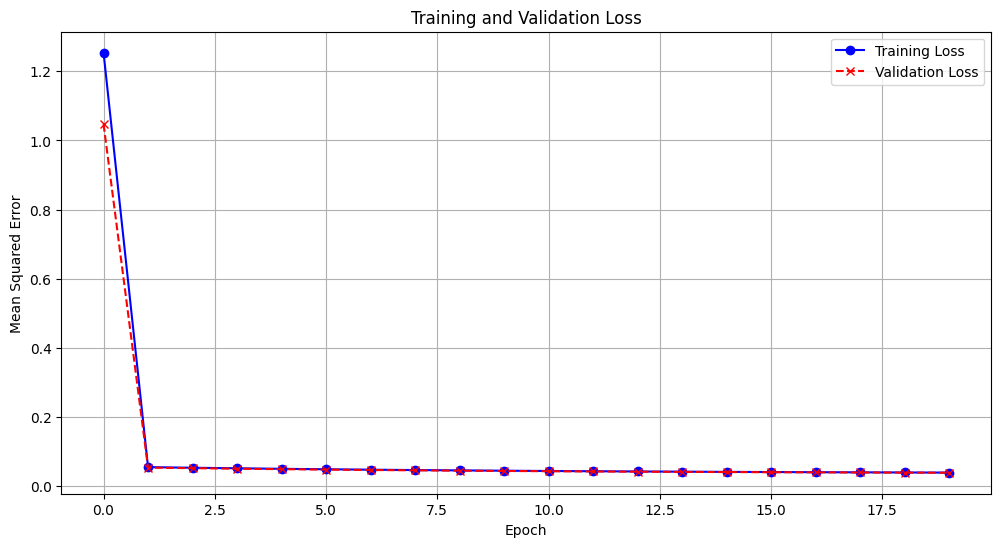

In [234]:
plt.figure(figsize=(12, 6))

plt.plot(train_losses, label='Training Loss', color='blue', linestyle='-', marker='o')

plt.plot(valid_losses, label='Validation Loss', color='red', linestyle='--', marker='x')

plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)

plt.show()

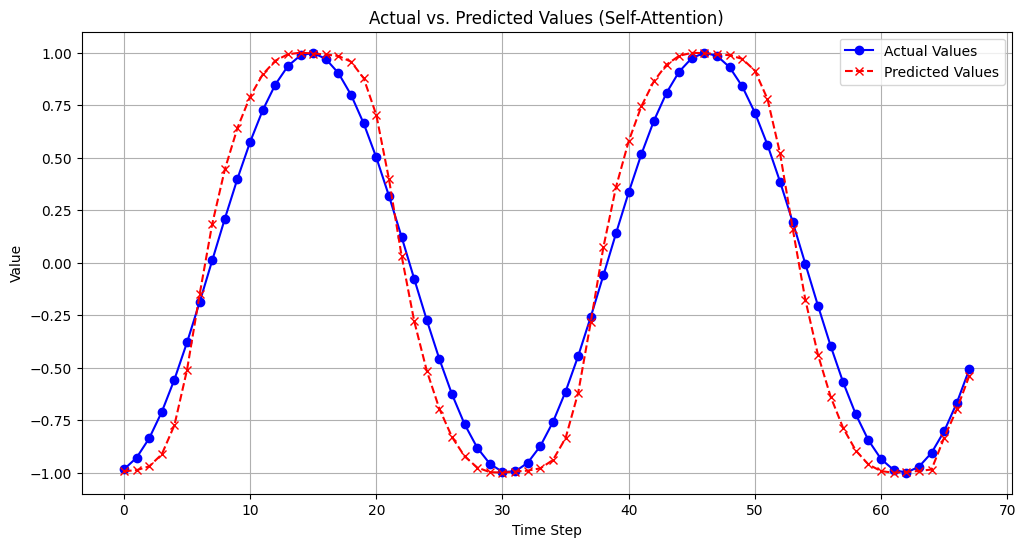

In [200]:
sequence_len = 7
predictions = []

for j in range(test_x.shape[0] - sequence_len):
    seq_x = test_x[j:(j + sequence_len), :]
    outputs, _ = self_attention_forward(seq_x, layers)
    output = outputs[-1]  # Last time step's prediction

    if output.ndim == 2:
        predictions.append(output[-1])  # Append the last timestep's prediction
    else:
        raise ValueError("Unexpected output shape")


# Normalize predictions to [0, 1]
pred_min = np.min(predictions)
pred_max = np.max(predictions)

normalized_predictions = (predictions - pred_min) / (pred_max - pred_min)

# Scale normalized predictions to [-1, 1]
scaled_predictions = 2 * normalized_predictions - 1


# Since predictions start at index `sequence_len`, ensuring that alignment
actual = test_y[sequence_len:sequence_len + len(predictions)]

plt.figure(figsize=(12, 6))

plt.plot(range(len(actual)), actual, label='Actual Values', color='blue', linestyle='-', marker='o')

plt.plot(range(len(scaled_predictions)), scaled_predictions, label='Predicted Values', color='red', linestyle='--', marker='x')

plt.xlabel('Time Step')
plt.ylabel('Value')
plt.title('Actual vs. Predicted Values (Self-Attention)')
plt.legend()
plt.grid(True)

plt.show()


## Cosine Prediction

In [175]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

x = np.linspace(0, 100, 500)
data = pd.DataFrame({
    'sine': np.sin(x),
    'cosine': np.cos(x),
})

data['cosine_next'] = data['cosine'].shift(-1)
data.dropna(inplace=True)

PREDICTORS = ["sine", "cosine"]
TARGETS = ["cosine_next"]

In [176]:
# Split the data into train, valid, and test sets
np.random.seed(0)
split_data = np.split(data, [int(.7*len(data)), int(.85*len(data))])
(train_x, train_y), (valid_x, valid_y), (test_x, test_y) = [
    [d[PREDICTORS].to_numpy(), d[TARGETS].to_numpy()] for d in split_data
]

print("Training data shape:", train_x.shape, train_y.shape)
print("Validation data shape:", valid_x.shape, valid_y.shape)
print("Test data shape:", test_x.shape, test_y.shape)

Training data shape: (349, 2) (349, 1)
Validation data shape: (75, 2) (75, 1)
Test data shape: (75, 2) (75, 1)


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [177]:
import numpy as np
import matplotlib.pyplot as plt

layer_conf = [
    {"type":"input", "units": 2},
    {"type": "self_attention", "hidden": 8, "output": 1}
]
layers = init_self_attention_params(layer_conf)

epochs = 2000
lr = 1e-3

# Training the model
for epoch in range(epochs):
    sequence_len = 7
    epoch_loss = 0
    for j in range(train_x.shape[0] - sequence_len):
        seq_x = train_x[j:(j+sequence_len),]
        seq_y = train_y[j:(j+sequence_len),]
        outputs, attentions = self_attention_forward(seq_x, layers)
        grad = mse_grad(seq_y, outputs)
        layers = self_attention_backward(layers, seq_x, lr, grad, attentions)
        epoch_loss += mse(seq_y, outputs)

    if epoch % 50 == 0:
        sequence_len = 7
        valid_loss = 0
        for j in range(valid_x.shape[0] - sequence_len):
            seq_x = valid_x[j:(j+sequence_len),]
            seq_y = valid_y[j:(j+sequence_len),]
            outputs, _ = self_attention_forward(seq_x, layers)
            valid_loss += mse(seq_y, outputs)

        print(f"Epoch: {epoch} train loss {epoch_loss / len(train_x)} valid loss {valid_loss / len(valid_x)}")


Epoch: 0 train loss 1.7721056766259982 valid loss 1.4766555172335802
Epoch: 50 train loss 0.06521767770794261 valid loss 0.061157933792882334
Epoch: 100 train loss 0.06292715405908036 valid loss 0.058993996913801194
Epoch: 150 train loss 0.06046638413045097 valid loss 0.0566726347190042
Epoch: 200 train loss 0.05816356138242361 valid loss 0.05448868958221611
Epoch: 250 train loss 0.055998437973683535 valid loss 0.05243020446868451
Epoch: 300 train loss 0.05396936248027774 valid loss 0.050499772003497846
Epoch: 350 train loss 0.05208040310293529 valid loss 0.04870306504060166
Epoch: 400 train loss 0.050332755213510355 valid loss 0.04704183354251818
Epoch: 450 train loss 0.04872327360785503 valid loss 0.04551317833254337
Epoch: 500 train loss 0.047245516095698575 valid loss 0.04411085982058742
Epoch: 550 train loss 0.0458911100568011 valid loss 0.04282673727132316
Epoch: 600 train loss 0.04465082388410696 valid loss 0.041651846744136016
Epoch: 650 train loss 0.04351528020404076 valid los

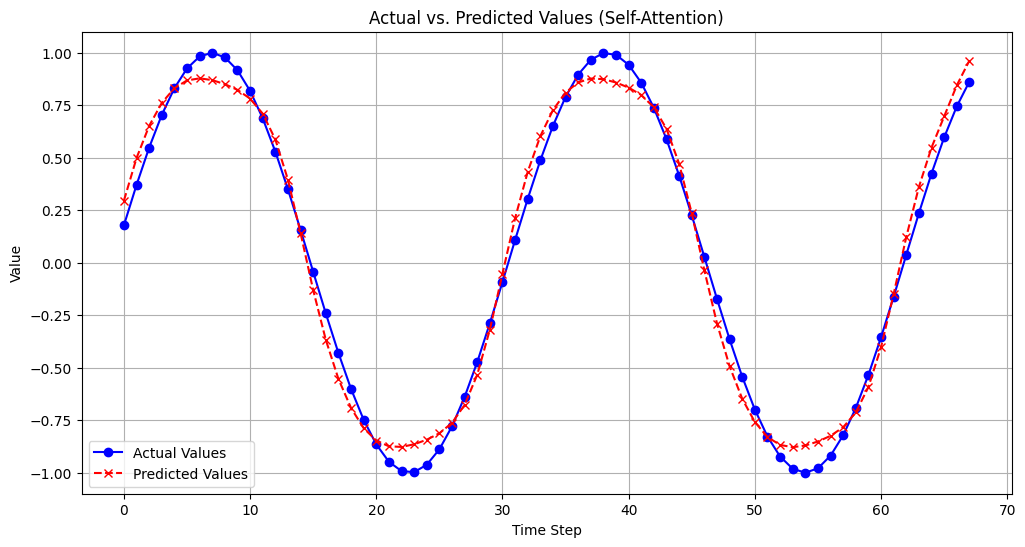

In [190]:
sequence_len = 7
predictions = []

for j in range(test_x.shape[0] - sequence_len):
    seq_x = test_x[j:(j + sequence_len), :]
    outputs, _ = self_attention_forward(seq_x, layers)
    output = outputs[-1]  # Last time step's prediction

    if output.ndim == 2:
        predictions.append(output[-1])  # Append the last timestep's prediction
    else:
        raise ValueError("Unexpected output shape")


# Normalize predictions to [0, 1]
pred_min = np.min(predictions)
pred_max = np.max(predictions)

normalized_predictions = (predictions - pred_min) / (pred_max - pred_min)

# Scale normalized predictions to [-1, 1]
scaled_predictions = 2 * normalized_predictions - 1

scaled_predictions = np.array(scaled_predictions).flatten()

# Since predictions start at index `sequence_len`, ensuring that alignment
actual = test_y[sequence_len:sequence_len + len(predictions)]


plt.figure(figsize=(12, 6))


plt.plot(range(len(actual)), actual, label='Actual Values', color='blue', linestyle='-', marker='o')

plt.plot(range(len(scaled_predictions)), scaled_predictions, label='Predicted Values', color='red', linestyle='--', marker='x')

plt.xlabel('Time Step')
plt.ylabel('Value')
plt.title('Actual vs. Predicted Values (Self-Attention)')
plt.legend()
plt.grid(True)

plt.show()
